# Chapter 2 End-to-End Machine Learning Project

This chapter contains an example of an end to end machine learning project where you try to predict median house values. 

## Big Picture

We are trying to predict a number, so this is a regression problem. The data comes labelled, so it is supervised. Since the data will remain unchanged for a while, we can go with batch learning rather than online learning.

## Getting the Data

In [121]:
import pandas as pd
import numpy as np
import os
import tarfile
import matplotlib.pyplot as plt
%matplotlib inline
from six.moves import urllib
from sklearn.model_selection import train_test_split

In [2]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join('datasets', 'housing')
FILENAME = 'housing.tgz'
HOUSING_URL = DOWNLOAD_ROOT + HOUSING_PATH + '/' + FILENAME

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH, filename=FILENAME):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
        print(f'Created {housing_path} directory')
    tgz_path = os.path.join(housing_path, FILENAME)
    urllib.request.urlretrieve(housing_url, tgz_path)
    print(f'{filename} downloaded')
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    print(f'{filename} extracted to {housing_path}')
    housing_tgz.close()

In [3]:
fetch_housing_data()

housing.tgz downloaded
housing.tgz extracted to datasets/housing


In [4]:
# Check contents of directory 
! ls datasets/housing

housing.csv  housing.tgz


## Exploring the Data

In [5]:
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [6]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [7]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [8]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


We can see missing values in total bedrooms. It also looks like we should find out what the numbers in median_income represent (there seems to be a cut-off at 15 which we should inquire into). 

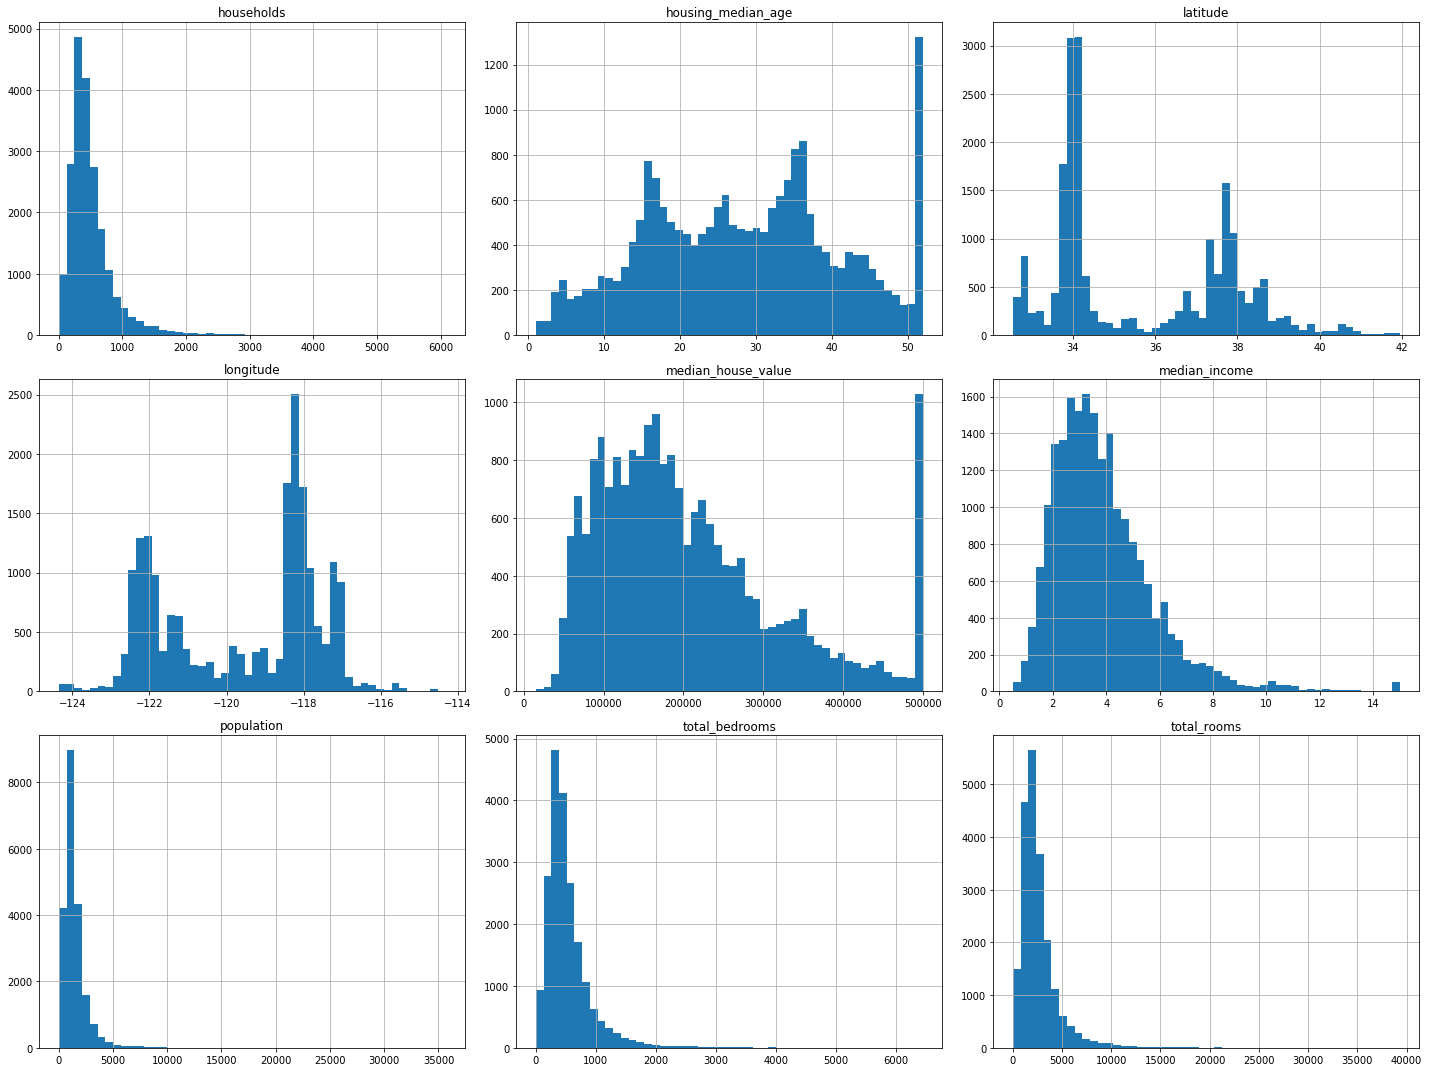

In [9]:
housing.hist(bins=50, figsize=(20, 15));
plt.tight_layout()
plt.show()

Let's say we wanted to generate training and testing data using stratified sampling on median income. 

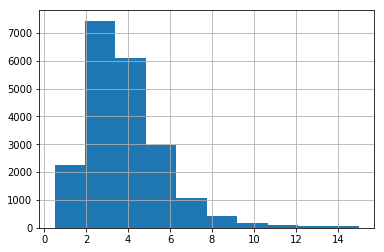

In [10]:
housing['median_income'].hist();

In [11]:
# Use median income to create categorical variable

# Divide by 1.5 to reduce number of categories and round up using ceiling
housing['income_cat'] = np.ceil(housing['median_income'] / 1.5)
# Turn all values greater than 5 to 5
housing['income_cat'].where(housing['income_cat'] < 5, 5.0, inplace=True)
# Check number of categories 
housing['income_cat'].value_counts()

3.0    7236
2.0    6581
4.0    3639
5.0    2362
1.0     822
Name: income_cat, dtype: int64

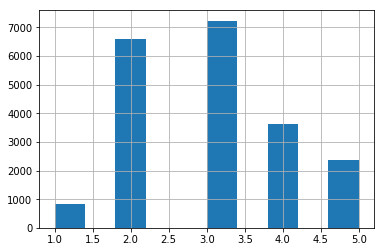

In [12]:
housing['income_cat'].hist();

In [13]:
X_train, X_test, y_train, y_test = train_test_split(housing, housing['median_house_value'], 
                                                    stratify=housing['income_cat'])

# Check if proportions are preserved
X_train['income_cat'].value_counts() / X_train.shape[0]

3.0    0.350581
2.0    0.318863
4.0    0.176292
5.0    0.114406
1.0    0.039858
Name: income_cat, dtype: float64

In [14]:
housing['income_cat'].value_counts() / housing.shape[0]

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

/home/hussain/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


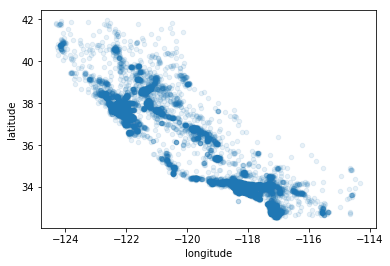

In [15]:
# Remove categorical income variable from our data
for data in (X_train, X_test):
    data.drop('income_cat', axis=1, inplace=True)

housing = X_train.copy()
# Use transparency option to look at density of population
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.1);

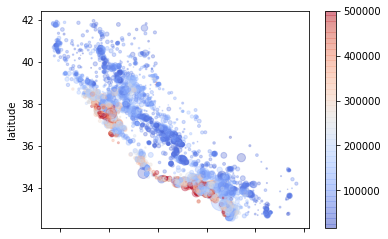

In [16]:
# Visualize density with marker size and color code housing prices
housing.plot(kind='scatter', x='longitude', y='latitude', 
             s=housing['population']/100 ,alpha=0.3,
             c=y_train, cmap=plt.cm.coolwarm);

We can see that population density and proximity to the ocean seem to be good predictors of median housing value.

In [17]:
# Create correlation matrix
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.684344
total_rooms           0.130658
housing_median_age    0.107167
households            0.062324
total_bedrooms        0.045778
population           -0.027000
longitude            -0.048659
latitude             -0.140182
Name: median_house_value, dtype: float64

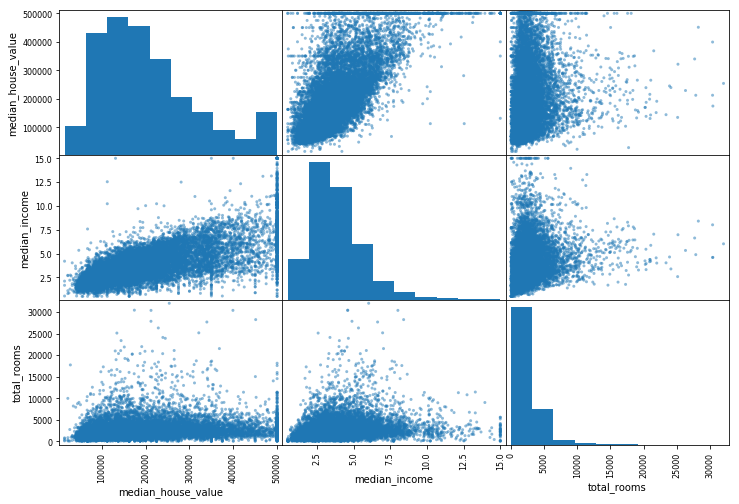

In [18]:
from pandas.plotting import scatter_matrix

# Grab 3 most correlated variables (including the variable itself)
attributes = list(corr_matrix['median_house_value'].sort_values(ascending=False).index[:3])

scatter_matrix(housing[attributes], figsize=(12, 8));

## Feature Engineering

In [19]:
list(housing.columns)

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'median_house_value',
 'ocean_proximity']

In [20]:
housing['rooms_per_household'] = housing['total_rooms'] / housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms'] / housing['total_rooms']
housing['population_per_household'] = housing['population'] / housing['households']

corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.684344
rooms_per_household         0.144065
total_rooms                 0.130658
housing_median_age          0.107167
households                  0.062324
total_bedrooms              0.045778
population                 -0.027000
population_per_household   -0.032133
longitude                  -0.048659
latitude                   -0.140182
bedrooms_per_room          -0.252473
Name: median_house_value, dtype: float64

## Data Cleaning (with Transformers and Pipelines!)

In [21]:
# Separate data into predictors and target values and make copies for testing
housing = X_train.drop('median_house_value', axis=1)
housing_labels = y_train.copy()

We noted above that total bedrooms had some missing values. We can take care of this with the Imputer transformer if we'd like to fill in these values.

In [22]:
from sklearn.impute import SimpleImputer

# Use median of attribute to fill in missing values
imputer = SimpleImputer(strategy='median')
# Create copy of data containing only numeric data
housing_num = housing.drop('ocean_proximity', axis=1)
housing_num.dtypes

longitude             float64
latitude              float64
housing_median_age    float64
total_rooms           float64
total_bedrooms        float64
population            float64
households            float64
median_income         float64
dtype: object

In [23]:
# Store median values
imputer.fit(housing_num)
# Check that median values were stored correctly
imputer.statistics_, housing_num.median().values

(array([-118.49,   34.25,   29.  , 2125.  ,  434.  , 1161.  ,  409.  ,
           3.54]),
 array([-118.49,   34.25,   29.  , 2125.  ,  434.  , 1161.  ,  409.  ,
           3.54]))

In [24]:
# Return array with filled in missing values
X = imputer.transform(housing_num)
# Store as dataframe
housing_tr = pd.DataFrame(X, columns=housing_num.columns)

housing_tr.isnull().values.any()

False

We also need to encode categorical variables numerically for proper use in our machine learning models.

In [25]:
from sklearn.preprocessing import OneHotEncoder

# Take categorical variables
housing_cat = housing['ocean_proximity']
encoder = OneHotEncoder()
# Transform categorical variables to one-hot vectors
housing_cat_encoded = encoder.fit_transform(np.array(housing_cat).reshape(-1, 1))
pd.DataFrame(housing_cat_encoded.todense(), columns=list(encoder.categories_)).head()

,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0


Let's also create a custom transformer class that combines attributes like we did manually above.

In [26]:
from sklearn.preprocessing import FunctionTransformer

# Get indices of columns we will combine
rooms_ix, bedrooms_ix, household_ix = [
    list(housing.columns).index(col)
    for col in ("total_rooms", "total_bedrooms", "households")]

# Define function to use in transformer
def add_extra_features(X, add_bedrooms_per_room=True):
    rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
    if add_bedrooms_per_room:
        bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
        return np.c_[X, rooms_per_household, bedrooms_per_room]
    else:
        return np.c_[X, rooms_per_household]

attr_adder = FunctionTransformer(add_extra_features, validate=False,
                                 kw_args={"add_bedrooms_per_room": False})
housing_extra_attribs = attr_adder.fit_transform(housing_num.values)
extra_attribs_cols = list(housing_num.columns) + ['rooms_per_household']
pd.DataFrame(housing_extra_attribs, columns = extra_attribs_cols).head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_household
0,-122.29,37.81,26.0,768.0,152.0,392.0,127.0,1.7719,6.047244
1,-117.91,34.04,15.0,8749.0,1761.0,5278.0,1691.0,4.6324,5.173862
2,-121.00,39.09,7.0,439.0,84.0,246.0,80.0,3.0781,5.487500
3,-117.95,33.92,13.0,2312.0,592.0,2038.0,559.0,3.1378,4.135957
4,-117.74,34.03,27.0,3623.0,809.0,3712.0,754.0,3.4609,4.805040


Now we can combine the above steps (and add scaling) using a Pipeline. We'll first create a pipeline for our numerical values.

In [27]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('attrs_adder', FunctionTransformer(add_extra_features, validate=False)),
    ('std_scaler', StandardScaler())
])

housing_num_tr = num_pipeline.fit_transform(housing_num)

# Create DataFrame for inspection
extra_attribs_cols.append('bedrooms_per_room')
housing_num_inspect = pd.DataFrame(housing_num_tr, columns=extra_attribs_cols)

# See if there are null values
print(housing_num_inspect.isnull().values.any())
# Look at column names and scaling
housing_num_inspect.describe()

False


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_household,bedrooms_per_room
count,1.548000e+04,1.548000e+04,1.548000e+04,1.548000e+04,1.548000e+04,1.548000e+04,1.548000e+04,1.548000e+04,1.548000e+04,1.548000e+04
mean,-2.245605e-15,1.017791e-15,5.579086e-17,8.296550e-17,-1.522325e-16,-2.896764e-17,9.543041e-17,9.512739e-17,-2.280628e-16,2.453320e-16
std,1.000032e+00,1.000032e+00,1.000032e+00,1.000032e+00,1.000032e+00,1.000032e+00,1.000032e+00,1.000032e+00,1.000032e+00,1.000032e+00
min,-2.354668e+00,-1.445444e+00,-2.191570e+00,-1.204611e+00,-1.272418e+00,-1.255289e+00,-1.303256e+00,-1.777419e+00,-1.745200e+00,-2.626829e+00
25%,-1.110098e+00,-7.948052e-01,-8.419932e-01,-5.459884e-01,-5.746497e-01,-5.693450e-01,-5.787345e-01,-6.914405e-01,-3.812279e-01,-5.941099e-01
50%,5.377129e-01,-6.450180e-01,3.126243e-02,-2.349470e-01,-2.471260e-01,-2.343081e-01,-2.387066e-01,-1.743876e-01,-7.842077e-02,-1.630391e-01
75%,7.816487e-01,9.745565e-01,6.663574e-01,2.324145e-01,2.583998e-01,2.649409e-01,2.791821e-01,4.636400e-01,2.337632e-01,4.075719e-01
max,2.618634e+00,2.959237e+00,1.857161e+00,1.343489e+01,1.158408e+01,3.020203e+01,1.190029e+01,5.868472e+00,5.191571e+01,3.982181e+01


Then we make a pipeline that will transform both our numerical and categorical variables.

In [84]:
from sklearn.compose import ColumnTransformer

# Get names of both types of attributes
num_attribs = list(housing_num)
cat_attribs = ['ocean_proximity']

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs),
])

housing_prepared = full_pipeline.fit_transform(housing)
prepared_df = pd.DataFrame(housing_prepared, columns = extra_attribs_cols + list(encoder.categories_[0]))
prepared_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_household,bedrooms_per_room,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
0,-1.354034,1.021365,-0.206898,-0.854746,-0.916414,-0.912317,-0.976306,-1.106699,0.233315,-0.246734,0.0,0.0,0.0,1.0,0.0
1,0.826453,-0.743316,-1.080154,2.790513,2.902323,3.395552,3.114492,0.401630,-0.098923,-0.195300,1.0,0.0,0.0,0.0,0.0
2,-0.711836,1.620514,-1.715249,-1.005014,-1.077802,-1.041042,-1.099239,-0.417945,0.020387,-0.347242,0.0,1.0,0.0,0.0,0.0
3,0.806540,-0.799486,-1.238928,-0.149536,0.127865,0.538922,0.153633,-0.386466,-0.493746,0.642311,1.0,0.0,0.0,0.0,0.0
4,0.911084,-0.747997,-0.127511,0.449253,0.642884,2.014847,0.663675,-0.216097,-0.239224,0.141356,0.0,1.0,0.0,0.0,0.0


## Model Fitting and Evaluation

In [29]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [30]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68897.62976504512

We look at the distribution of median housing values to get some idea of the magnitude of our error.

In [31]:
X_train.describe()['median_house_value']

count     15480.000000
mean     207120.628618
std      115505.108085
min       14999.000000
25%      120100.000000
50%      180200.000000
75%      264125.000000
max      500001.000000
Name: median_house_value, dtype: float64

In [32]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [33]:
housing_predictions = tree_reg.predict(housing_prepared)
dtr_mse = mean_squared_error(housing_labels, housing_predictions)
dtr_rmse = np.sqrt(dtr_mse)
dtr_rmse

0.0

A 0% error on our training set highly suggests that our model overfit the data. We can use cross-validation to explore further.

In [34]:
from sklearn.model_selection import cross_val_score

# 10-fold validation
scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                        scoring='neg_mean_squared_error', cv=10)
rmse_scores = np.sqrt(-scores)

In [35]:
# Define function for displaying info about cross-validated scores
def display_scores(scores):
    print('Scores:', scores)
    print('Mean:', scores.mean())
    print('Standard deviation: ', scores.std())
    
display_scores(rmse_scores)

Scores: [69217.01336233 69737.79674704 72342.00932616 68023.19707157
 70086.31825385 67437.9417502  74060.35445312 72633.70665572
 70549.30391483 74474.64306378]
Mean: 70856.22845986174
Standard deviation:  2303.518006362074


We can see now that the decision tree regression actually did worse on average than did the linear regression model. We can confirm this by performing a similar procedure with linear regression.

In [36]:
scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                        scoring='neg_mean_squared_error', cv=10)
rmse_scores = np.sqrt(-scores)
display_scores(rmse_scores)

Scores: [72128.90323657 67537.54322123 70371.53174369 65838.8985076
 67840.91693812 67440.09193901 69584.46999021 73322.80057609
 68807.80817252 68643.83088369]
Mean: 69151.67952087244
Standard deviation:  2157.340986570869


In [37]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=10)
scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                        scoring='neg_mean_squared_error', cv=10)
display_scores(-scores)

Scores: [2.62835512e+09 2.62915510e+09 3.00147389e+09 2.50358269e+09
 2.59680853e+09 2.60042497e+09 2.94728727e+09 2.96415884e+09
 2.81642962e+09 2.97423924e+09]
Mean: 2766191526.5649858
Standard deviation:  183320113.99139446


Let's use GridSearch to find better hyperparameters.

In [46]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 4]}
]

forest_reg = RandomForestRegressor(n_estimators=10)

rf_grid_search = GridSearchCV(forest_reg, param_grid, cv=5, 
                           scoring='neg_mean_squared_error')
rf_grid_search.fit(housing_prepared, housing_labels);

In [47]:
rf_grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=8, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=None, oob_score=False,
           random_state=None, verbose=0, warm_start=False)

In [48]:
final_model = rf_grid_search.best_estimator_

In [49]:
X_test_prepared = full_pipeline.transform(X_test)

test_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(test_predictions, y_test)
final_rmse = np.sqrt(final_mse)
final_rmse

48079.42237001227

# Exercises

## 1. 

Question: Try a Support Vector Machine regressor (sklearn.svm.SVR), with various hyperparameters such as kernel="linear" (with various values for the C hyperparameter) or kernel="rbf" (with various values for the C and gamma hyperparameters). Don't worry about what these hyperparameters mean for now. How does the best SVR predictor perform?

In [42]:
from sklearn.svm import SVR

param_grid = [{'kernel': ['linear'], 'C': [0.1, 1, 10, 100]},
              {'kernel': ['rbf'], 'C': [0.1, 1, 10, 100] , 'gamma': [0.0001, 0.001, 0.01, 0.1]}]

svr = SVR()

grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'kernel': ['linear'], 'C': [0.1, 1, 10, 100]}, {'kernel': ['rbf'], 'C': [0.1, 1, 10, 100], 'gamma': [0.0001, 0.001, 0.01, 0.1]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [44]:
svr_final = grid_search.best_estimator_
housing_preds = svr_final.predict(X_test_prepared)
svr_mse = mean_squared_error(housing_preds, y_test)
svr_rmse = np.sqrt(svr_mse)

print(grid_search.best_params_)
print(svr_rmse)

{'C': 100, 'kernel': 'linear'}
71199.91821146982


Since grid search picked the highest value of C, we should check higher values and see how it affects model performance. 

In [43]:
param_grid = [{'kernel': ['linear'], 'C': [100, 1000, 10000]}]

grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(housing_prepared, housing_labels)

svr_final = grid_search.best_estimator_
housing_preds = svr_final.predict(X_test_prepared)
svr_mse = mean_squared_error(housing_preds, y_test)
svr_rmse = np.sqrt(svr_mse)

print(grid_search.best_params_)
print(svr_rmse)

{'C': 10000, 'kernel': 'linear'}
68142.29997137017


## 3.

Question: Try adding a transformer in the preparation pipeline to select only the most important attributes (assume we already have ranked feature importances).

In [100]:
def keep_k_most_important_features(X, rankings=final_model.feature_importances_, k=5):
    # Find indices of k most important features
    feature_indices = np.sort(np.argpartition(np.array(rankings), -k)[-k:])
    # Keep only those columns in the dataframe
    return X[:,feature_indices]

preparation_and_feature_selection_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', FunctionTransformer(keep_k_most_important_features, validate=False))
])

In [104]:
housing_prepared_top_k_features = preparation_and_feature_selection_pipeline.fit_transform(housing)
housing_prepared_top_k_features[:5,:]

array([[-1.35403394,  1.02136506, -1.10669892, -0.24673357,  0.        ],
       [ 0.8264532 , -0.74331584,  0.40163002, -0.19529995,  0.        ],
       [-0.71183567,  1.62051401, -0.41794547, -0.34724197,  1.        ],
       [ 0.80654007, -0.79948606, -0.38646592,  0.64231117,  0.        ],
       [ 0.91108398, -0.7479967 , -0.21609673,  0.14135592,  1.        ]])

Let's check whether we indeed kept the k most important features.

In [107]:
def k_most_important_features_indices(X, rankings=final_model.feature_importances_, k=5):
    # Find indices of k most important features
    return np.sort(np.argpartition(np.array(rankings), -k)[-k:])

indices = k_most_important_features_indices(prepared_df)
prepared_df.iloc[:5, indices]

,longitude,latitude,median_income,bedrooms_per_room,INLAND
0,-1.354034,1.021365,-1.106699,-0.246734,0.0
1,0.826453,-0.743316,0.401630,-0.195300,0.0
2,-0.711836,1.620514,-0.417945,-0.347242,1.0
3,0.806540,-0.799486,-0.386466,0.642311,0.0
4,0.911084,-0.747997,-0.216097,0.141356,1.0


## 4.

Question: Try creating a single pipeline that does the full data preparation plus the final prediction.

In [115]:
prepare_select_and_predict_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', FunctionTransformer(keep_k_most_important_features, validate=False,
                                             kw_args={"k": 10})),
    ('rf_reg', RandomForestRegressor(**rf_grid_search.best_params_))
])

prepare_select_and_predict_pipeline.fit(housing, housing_labels);

In [120]:
some_data = housing.iloc[:4]
some_labels = housing_labels.iloc[:4]

print("Predictions:\t", prepare_select_and_predict_pipeline.predict(some_data))
print("Labels:\t\t", [i for i in some_labels])

Predictions:	 [ 88130.         183623.33333333 150706.66666667 143793.33333333]
Labels:		 [82500.0, 168800.0, 162500.0, 137000.0]
